In [ ]:
from typing_extensions import Literal
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.graph import START, END, StateGraph
from notebooks.output_formatters import format_graph_output_summary


model = ChatOllama(
    model="gpt-oss:120b-cloud",
    temperature=0.1,
)

class State(TypedDict):
    messages: Annotated[list, add_messages]


generate_prompt = SystemMessage("""
    You are an essay assistant tasked with writing excellent 3-paragraph essays.
    """
    "Generate the best essay possible for the user's request."
    """If the user provides critique, respond with a revised version of your previous attempts"""
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages": [answer]}

reflection_prompt = SystemMessage("""
    You are a techera grading an essay submission. Generate critique and recommendations for the user's submission.
"""
"""
    ¨Provide detailed recommendations, including requests for length, depth, style, etc.
"""
)

def reflect(state: State) -> State:
    cls_map = {
        AIMessage: HumanMessage,
        HumanMessage: AIMessage,
    }

    translated = [reflection_prompt, state["messages"][0]] + [
        cls_map[msg.__class__](content=msg.content) for msg in state["messages"][1:]
    ]

    answer = model.invoke(translated)

    return {"messages": [HumanMessage(content=answer.content)]}

def should_continue(state: State) -> Literal["reflect", END]:
    if len(state["messages"]) > 6:
        return END
    else:
        return "reflect"

builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()

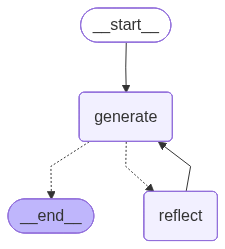

In [3]:
from IPython.display import Image

png = graph.get_graph().draw_mermaid_png()

Image(png)


In [4]:
from langchain_core.messages import HumanMessage

input_message = {"messages": [
    HumanMessage(content="""
    Generate an essay about tennis.
                 """),
]}

calls = []

for c in graph.stream(input_message):
    calls.append(c)

In [5]:
format_graph_output_summary(calls)

GRAPH EXECUTION SUMMARY (Condensed)

────────────────────────────────────────────────────────────────────────────────
Step 1: GENERATE
────────────────────────────────────────────────────────────────────────────────

  [AIMessage]
  **Tennis: A Sport of Skill, Strategy, and Global Appeal**

Tennis, often described as a graceful duel between two opponents, has evolved from a leisurely pastime of aristocrats into a worldwide competitive sport that captivates millions. Originating in 12th‑century France as “jeu de paume,” the game transformed over centuries—adopting standardized rules, modern equipment, and a professional circuit that now spans continents. Its unique blend of physical agility, mental acuity, and tactical nuance makes tennis not merely a test of endurance but a sophisticated contest of intellect and precision.

At its core, tennis demands a harmonious balance of speed, power, and finesse. Players must master a repertoire of strokes—forehands, backhands, serves, volleys, an

# Subgraphs

In [15]:
class State(TypedDict):
    foo: str

class SubgraphState(TypedDict):
    bar: str
    baz: str

def subgraph_node(state: SubgraphState):
    return {
        "bar" : state["bar"] + "baz"
    }

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node("subgraph_node", subgraph_node)
subgraph_builder.add_edge(START, "subgraph_node")

subgraph = subgraph_builder.compile()

def node(state: State):
    response = subgraph.invoke({
        "bar": state["foo"],
    })

    return {
        "foo": response["bar"],
    }

builder = StateGraph(State)
builder.add_node("node", node)
builder.add_edge(START, "node")

graph = builder.compile()

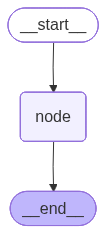

In [ ]:
from IPython.display import Image

png_subgraph = subgraph.get_graph().draw_mermaid_png()

png_graph = graph.get_graph().draw_mermaid_png()

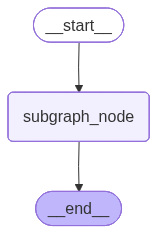

In [27]:
Image(png_subgraph)

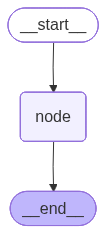

In [28]:
Image(png_graph)

# Supervisor Multi-agent Architecture

In [ ]:
from pydantic import BaseModel
from typing_extensions import Literal
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.graph import START, END, StateGraph
from notebooks.output_formatters import format_graph_output_summary

class SupervisorDecision(BaseModel):
    next: Literal["researcher", "coder", "FINISH"]


model = ChatOllama(
    model="gpt-oss:120b-cloud",
    temperature=0.1,
)

class AgentState(TypedDict):
    next: Literal["researcher", "coder", "FINISH"]
    messages: Annotated[list, add_messages]

agents = ["researcher", "coder"]

system_prompt_prev = f"""
    You are a supervisor tasked with managing a conversation between the following workers: {agents}.
    Given the following user request, respond with the worker to act next.
    Each worker will perform a task and respond with their results and status.
    When finished, respond with FINISH.
"""

system_prompt_post = f"""
    Given the conversation above, who should act next? Or should we FINISH?
    Select one of: {', '.join(agents)}, FINISH.
"""


def supervisor(state : AgentState):
    messages = [
        ("system", system_prompt_prev),
        *state["messages"],
        ("system", system_prompt_post),
    ]

    answer = model.invoke(messages)
    return {"next": answer.content}


In [86]:
from typing import List


model_worker = ChatOllama(
    model="gpt-oss:120b-cloud",
    temperature=0.1,
)

def convert_last_message_to_human(messages: List):
    messages = messages[:-1] + [
        HumanMessage(content=messages[-1].content)
    ]
    return messages

reasercher_prompt = SystemMessage("""
    You are a researcher tasked with gathering information on a given topic.
    Provide a detailed report of your findings.
""")

def researcher(state : AgentState):
    messages = [reasercher_prompt, *state["messages"]]
    answer = model.invoke(messages)
    return {"messages": [answer]}

coder_prompt = SystemMessage("""
    You are a coder tasked with writing code based on the user's request.
    Provide well-documented code snippets.
""")

def coder(state : AgentState):
    messages = [coder_prompt, *state["messages"]]
    messages = convert_last_message_to_human(messages)
    answer = model.invoke(messages)
    return {"messages": [answer]}

def should_continue(state: AgentState) -> Literal["researcher", "coder", END]:
    if len(state["messages"]) > 6 or state["next"] == "FINISH":
        return END
    elif state["next"] == "researcher":
        return "researcher"
    elif state["next"] == "coder":
        return "coder"

builder = StateGraph(AgentState)
builder.add_node("supervisor", supervisor)
builder.add_node("researcher", researcher)
builder.add_node("coder", coder)
builder.add_edge(START, "supervisor")
builder.add_conditional_edges("supervisor", should_continue)
builder.add_edge("researcher", "supervisor")
builder.add_edge("coder", "supervisor")

supervisor_graph = builder.compile()


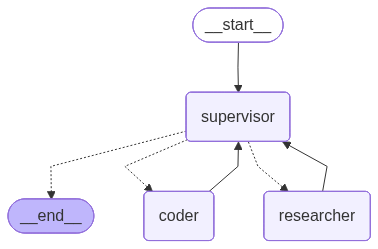

In [78]:
from IPython.display import Image

png_supervisor_graph = supervisor_graph.get_graph().draw_mermaid_png()

Image(png_supervisor_graph)

In [88]:
from langchain_core.messages import HumanMessage

input_message = {"messages": [
    HumanMessage(content="""
    Create a Python script that emulates a tennis scorekeeper.
                 """),
]}

calls = []

for c in supervisor_graph.stream(input_message):
    calls.append(c)

In [89]:
calls

[{'supervisor': {'next': 'researcher'}},
 {'researcher': {'messages': [AIMessage(content='Below is a **stand‑alone Python script** that can be used as a simple tennis‑score keeper.  \nIt supports:\n\n* Point‑by‑point scoring (0,\u202f15,\u202f30,\u202f40,\u202fAdvantage, Game)  \n* Game counting within a set (including deuce/advantage logic)  \n* Set counting (first to 6 games, win by 2; optional tiebreak at 6‑6)  \n* Best‑of‑3 or best‑of‑5 match formats  \n* A tiny command‑line interface so you can play a match interactively  \n* A small test harness that can be run with `python -m unittest`  \n\nYou can copy the whole file into `tennis_scorekeeper.py` and run it directly:\n\n```bash\npython tennis_scorekeeper.py          # interactive mode\npython -m unittest tennis_scorekeeper.py   # run the built‑in tests\n```\n\n---\n\n## 1.  Full source code\n\n```python\n#!/usr/bin/env python3\n"""\ntennis_scorekeeper.py\n\nA lightweight tennis match score keeper that can be used from the comman

In [90]:
format_graph_output_summary(calls)

GRAPH EXECUTION SUMMARY (Condensed)

────────────────────────────────────────────────────────────────────────────────
Step 1: SUPERVISOR
────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────
Step 2: RESEARCHER
────────────────────────────────────────────────────────────────────────────────

  [AIMessage]
  Below is a **stand‑alone Python script** that can be used as a simple tennis‑score keeper.  
It supports:

* Point‑by‑point scoring (0, 15, 30, 40, Advantage, Game)  
* Game counting within a set (including deuce/advantage logic)  
* Set counting (first to 6 games, win by 2; optional tiebreak at 6‑6)  
* Best‑of‑3 or best‑of‑5 match formats  
* A tiny command‑line interface so you can play a match interactively  
* A small test harness that can be run with `python -m unittest`  

You can copy the whole file into `tennis_scorekeeper.py` and run it directly:

```bash
python tenn

# Annex

In [ ]:
from pydantic import BaseModel, Field

class Joke(BaseModel):
    setup: str = Field(..., description="The setup of the joke")
    punchline: str = Field(..., description="The punchline of the joke")

# It didn't work


In [134]:
from langchain_ollama import ChatOllama

model= ChatOllama(
    model="deepseek-v3.1:671b-cloud",
    temperature=0,
)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def joker(state : State):
    messages = [*state["messages"]]
    answer = model.invoke(messages)
    return {"messages": [answer]}

builder = StateGraph(State)
builder.add_node("joker", joker)
builder.add_edge(START, "joker")

graph = builder.compile()


In [135]:
input_message = {
    "messages" : [
        HumanMessage(content="Tell me a joke about cats.")
    ]
}

output = graph.astream_events(input_message, version="v2")

async for event in output:
    print(event)


{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me a joke about cats.', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '31c4601e-97a5-4223-a2c0-e421551ccf74', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me a joke about cats.', additional_kwargs={}, response_metadata={}, id='0ccadafd-f71d-4098-a643-0f192df33013')]}}, 'name': 'joker', 'tags': ['graph:step:1'], 'run_id': '3e4b0b82-545f-429f-9af4-4058e512f2c8', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'joker', 'langgraph_triggers': ('branch:to:joker',), 'langgraph_path': ('__pregel_pull', 'joker'), 'langgraph_checkpoint_ns': 'joker:7197f605-9b95-34f3-b4a0-ed8cf18a04b2'}, 'parent_ids': ['31c4601e-97a5-4223-a2c0-e421551ccf74']}
{'event': 'on_chain_stream', 'run_id': '3e4b0b82-545f-429f-9af4-4058e512f2c8', 'name': 'joker', 'tags': ['graph:step:1'], 'metadata': {'langgraph_st